This notebook summarizes how the classifier for H5N1 markets was trained


In [3]:
import sqlite3
import pandas as pd

# read in the markets from the manifold_markets.db database which holds 10000 markets from the Manifold API
# df = pd.read_sql("SELECT * FROM markets", con=sqlite3.connect('manifold_markets.db'))

# using Gemini and the groups.csv file which has all of the market tags from the undocumented api 
# https://pxidrgkatumlvfqaxcll.supabase.co/rest/v1/groups?apikey=eyJhbGciOiJIUzI1NiIsInR5cCI6Ik[…]d_yYtASLzAoIIGdXUBIgRAGLBnNow7JG2SoaNMQ8ySg&select=*
# I got 44 market tags that related to infectious disease or H5N1
# the only label that explicitly was applicable to H5N1 was the tag H5N1 Bird Flu
# all others such as World Health org, Covid etc. are not applicable to labeling H5N1 markets


# label the questions as H5N1 relating if they have the tag H5N1 Bird Flu
for index, row in df.iterrows():
    if row["group_labels"] == "" or row["group_labels"] is None:
        df.drop(index, inplace=True)
    # drop the labeled ones since we are adding them again and don't want to double count
    elif "H5N1 Bird Flu" in row["group_labels"]:
        df.drop(index, inplace=True)
    else:
        df.loc[index, "label"] = 0


# get markets that are labeled H5N1
# This database has all of the markets that were labeled H5N1
df_h5n1 = pd.read_sql("SELECT * FROM markets", con=sqlite3.connect('H5N1_markets.db'))
df_h5n1["label"] = 1
print(len(df_h5n1))
        
print(10000 - 891 - 46)
print(len(df))

# add the h5n1 markets
df = pd.concat([df, df_h5n1], ignore_index=True)

print((df["label"] == 1).sum())

104
9063
9063
104


# Bag of words base line

In [3]:
from sklearn.model_selection import train_test_split

# Split data into train, val, and test sets for all models
X_train, X_temp, y_train, y_temp = train_test_split(
    df['question'], df['label'], test_size=0.4, stratify=df['label'], random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# to use for final test once model parameters are chosen
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

# pipeline
pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2), stop_words='english', sublinear_tf=True)),
        ('classifier', LinearSVC(max_iter=20000, random_state=42, dual ='auto'))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = pipeline.predict(X_test)

# Evaluate
print("Classification Report for TfidfVectorizer and LinearSVC:")
print(classification_report(y_test, y_pred))


Classification Report for TfidfVectorizer and LinearSVC:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1813
         1.0       1.00      0.90      0.95        21

    accuracy                           1.00      1834
   macro avg       1.00      0.95      0.97      1834
weighted avg       1.00      1.00      1.00      1834



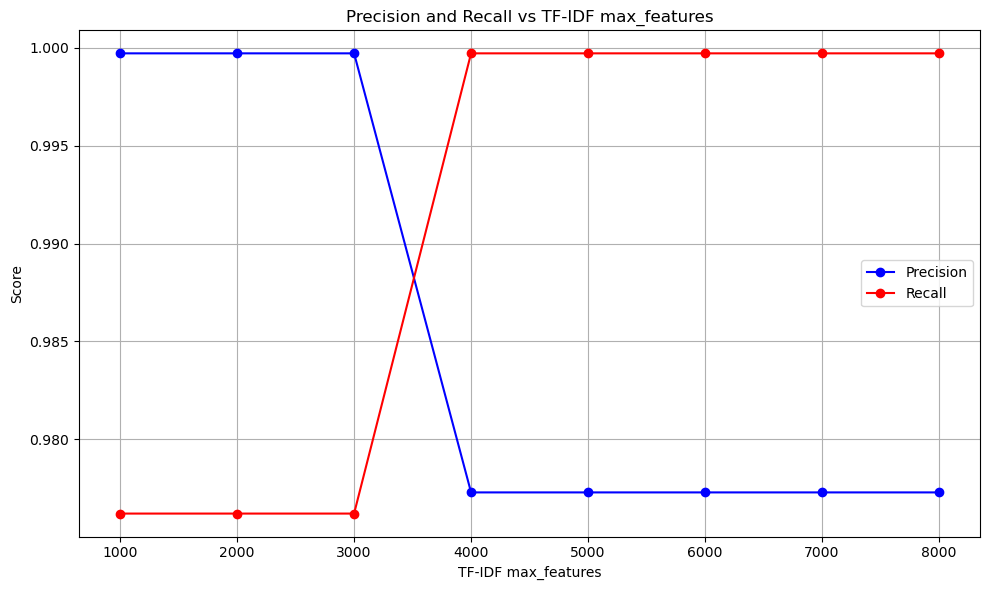


Best performance at 4000 max_features:
Precision: 0.977
Recall: 1.000


In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split


# Define different max_features to test
feature_steps = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

precisions = []
recalls = []

# Loop over different max_features values
for max_feat in feature_steps:
    # TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=max_feat, stop_words='english', ngram_range=(1, 2), sublinear_tf=True)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)
    
    # Classifier
    clf = LinearSVC(max_iter=20000, random_state=42, dual ='auto')
    clf.fit(X_train_vec, y_train)
    
    # Predictions
    y_pred = clf.predict(X_val_vec)
    
    # Evaluation
    precision = precision_score(y_val, y_pred, average='macro')  # or 'weighted'
    recall = recall_score(y_val, y_pred, average='macro')
    
    precisions.append(precision)
    recalls.append(recall)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(feature_steps, precisions, 'b-o', label='Precision')
plt.plot(feature_steps, recalls, 'r-o', label='Recall')
plt.xlabel('TF-IDF max_features')
plt.ylabel('Score')
plt.title('Precision and Recall vs TF-IDF max_features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the best result
best_idx = np.argmax([p + r for p, r in zip(precisions, recalls)])
print(f"\nBest performance at {feature_steps[best_idx]} max_features:")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall: {recalls[best_idx]:.3f}")


# Using Alibaba-NLP/gte-base-en-v1.5 Found from MTEB leaderboard

In [5]:
# using 'Alibaba-NLP/gte-base-en-v1.5'
# Requires sentence_transformers>=2.7.0
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('Alibaba-NLP/gte-base-en-v1.5', trust_remote_code=True)


# Encode only the training, val, and test sets separately
X_train_Alibaba = model.encode(X_train.tolist())
X_val_Alibaba = model.encode(X_val.tolist())
X_test_Alibaba = model.encode(X_test.tolist())

X_train_val_Alibaba = np.concatenate([X_train_Alibaba, X_val_Alibaba])
y_train_val_Alibaba = np.concatenate([y_train, y_val])


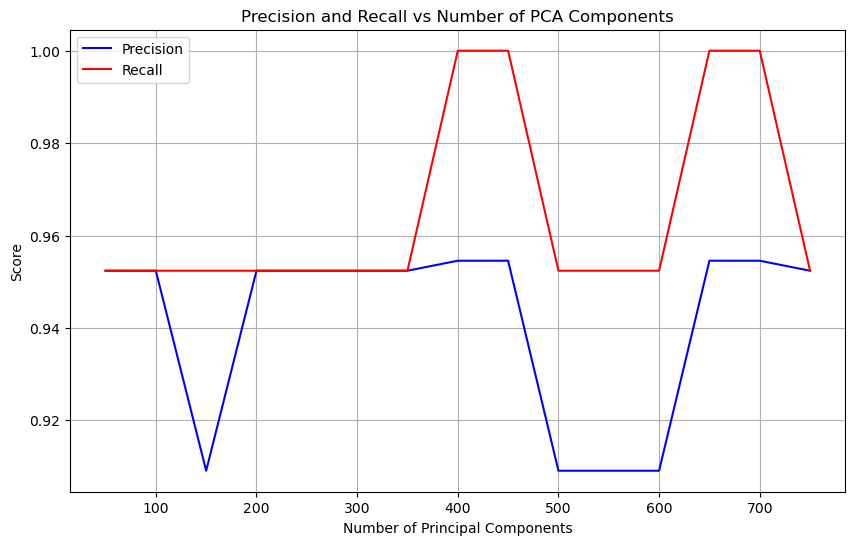


Best performance at 400 components:
Precision: 0.955
Recall: 1.000


In [63]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
np.random.seed(42)

# Calculate max components
max_components = X_train_Alibaba.shape[1]
component_steps = range(50, max_components + 1, 50)

precisions = []
recalls = []

for n_components in component_steps:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_Alibaba)
    X_val_pca = pca.transform(X_val_Alibaba)
    
    # Train classifier
    clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=42, max_iter=20000, dual ='auto'))
    clf.fit(X_train_pca, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_val_pca)
    
    # Calculate metrics
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(component_steps, precisions, 'b-', label='Precision')
plt.plot(component_steps, recalls, 'r-', label='Recall')
plt.xlabel('Number of Principal Components')
plt.ylabel('Score')
plt.title('Precision and Recall vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()

# Print the best results
best_idx = np.argmax([p + r for p, r in zip(precisions, recalls)])
print(f"\nBest performance at {component_steps[best_idx]} components:")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall: {recalls[best_idx]:.3f}") 

# Using nomic-ai/modernbert-embed-base

In [59]:
model2 = SentenceTransformer("nomic-ai/modernbert-embed-base")
sentences = []
 
X_train_Bert = model2.encode(['classification: ' + q for q in X_train])
X_val_Bert = model2.encode(['classification: ' + q for q in X_val])
X_test_Bert = model2.encode(['classification: ' + q for q in X_test])

X_train_val_bert = np.concatenate([X_train_Bert, X_val_Bert])
y_train_val_bert = np.concatenate([y_train, y_val])

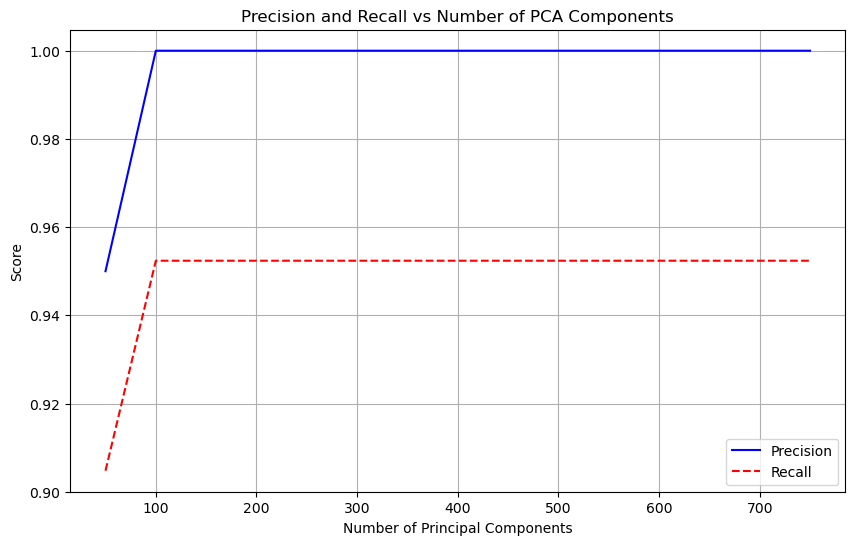


Best performance at 100 components:
Precision: 1.000
Recall: 0.952


In [65]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

np.random.seed(42)

# Calculate max components
max_components = X_train_Bert.shape[1]
component_steps = range(50, max_components + 1, 50)

precisions = []
recalls = []

for n_components in component_steps:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_Bert)
    X_val_pca = pca.transform(X_val_Bert)
    
    # Train classifier
    clf = LinearSVC(random_state=42, max_iter=20000, dual ='auto')
    clf.fit(X_train_pca, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_val_pca)
    
    # Calculate metrics
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(component_steps, precisions, 'b-', label='Precision')
plt.plot(component_steps, recalls, 'r--', label='Recall')
plt.xlabel('Number of Principal Components')
plt.ylabel('Score')
plt.title('Precision and Recall vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()

# Print the best results
best_idx = np.argmax([p + r for p, r in zip(precisions, recalls)])
print(f"\nBest performance at {component_steps[best_idx]} components:")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall: {recalls[best_idx]:.3f}") 

From above, I think that TDIDF and GTE are the best options because of the higher recall. We want to get all of the markets we can.

Predicted 1: During 2023, will multiple media sources report more than 100,000 people in the United States were infected with H5N1?
Predicted 1: Will H5N1 kill more than 10 thousand people in 2023?
Predicted 1: Will an H5N1 mRNA vaccine be developed and enter "late stage" human trials (or wider release) by July 2025?
Predicted 1: Will 100 people die of H5N1 in 2023?
Predicted 1: Will there be 500 or more human cases of H5N1 in the US by the end of 2025?
Predicted 1: Are you currently hedged against an H5N1-induced market crash?
Predicted 1: Will the WHO declare H5N1 a Public Health Emergency of International Concern in 2025?
Predicted 1: Will the CDC or WHO discourage non-essential travel due to H5N1 before July 2025?
Predicted 1: First confirmed human-to-human H5N1 transmission by May 1st 2025
Predicted 1: Will H5N1 (bird flu) kill at least 100 Americans in 2023?
Predicted 1: Will at least 100,000 Americans die of H5N1 by the end of 2024?
Predicted 1: First confirmed human-to-human H5

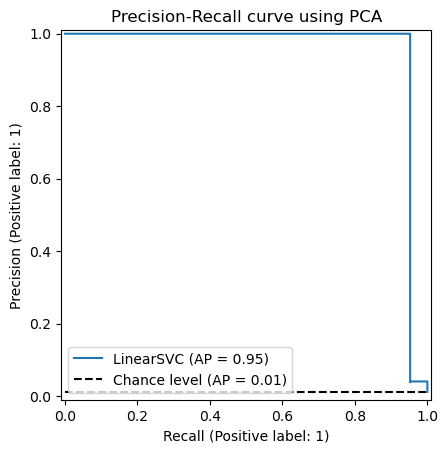

In [52]:
# pipeline
pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=4000, ngram_range=(1, 2), stop_words='english', sublinear_tf=True)),
        ('classifier', LinearSVC(max_iter=20000, random_state=42, dual ='auto'))
])


# Fit the pipeline
pipeline.fit(X_train_val, y_train_val)

# Score on test data
y_score = pipeline.decision_function(X_test)

# Print only predictions == 1
for i in range(len(X_test)):
    prediction = pipeline.predict([X_test.iloc[i]])[0]
    if prediction == 1:
        print(f"Predicted 1: {X_test.iloc[i]}")

# Evaluate
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve using PCA")

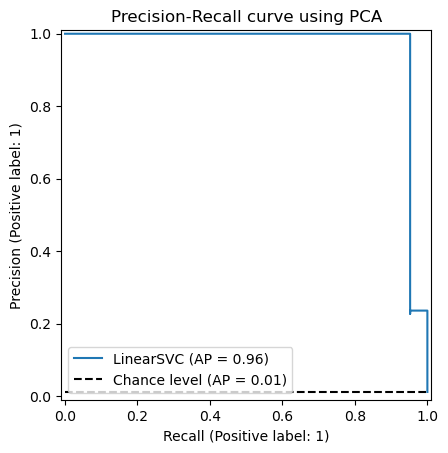

In [7]:

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC

clf = make_pipeline(PCA(n_components=400 , random_state=42),
                    LinearSVC(random_state=42, tol=1e-5, max_iter=20000, dual ='auto'))

clf.fit(X_train_val_Alibaba, y_train_val_Alibaba)

y_score = clf.decision_function(X_test_Alibaba)



from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve using PCA")

# Asking GTE model and TDIDF different questions

In [69]:
test_question = "Is human influenza going to be a global pandemic?"
#test_question = "Will the price of Costco chicken breast reach over $7 per pound by the end of 2025?"

#test_question = "Will there be a global pandemic in the next 3 years?" THIS QUESTION mBERT SAYS YES and TDIDF SAYS NO
#test_question = "Will H5N1 cause at least 10 human deaths globally by the end of 2025?"
test_question_embedding = model.encode(test_question).reshape(1, -1)

# GTE
clf_GTE = make_pipeline(PCA(n_components=500 , random_state=42),
                    LinearSVC(random_state=42, tol=1e-5, max_iter=20000, dual ='auto'))
clf_GTE.fit(X_train_val_Alibaba, y_train_val_Alibaba)

# TDIDF 
clf_TDIDF = make_pipeline(TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english', sublinear_tf=True),
                          LinearSVC(random_state=42, tol=1e-5, max_iter=20000, dual ='auto'))
clf_TDIDF.fit(X_train, y_train)


print(clf_GTE.predict(test_question_embedding))
print(clf_TDIDF.predict([test_question]))


[1.]
[0.]


In [78]:
# this csv file was created by Chat GPT using the following prompt:
# Generate a bunch of random question titles for prediction markets where some clearly relate to H5N1, 
# some clearly do not and some may or may not depending on interpretation. add them all to a csv file, make 100 
# followed up by the prompt: vary the question style and topics more, I want a diverse set 
# folowed up by the prompt: you repeat questions that are essentially asking the same thing in different wordings, 
# can you be more creative and never repeat questions that are getting at the same thing


test_questions_df = pd.read_csv('GPT_new_questions.csv')
counter = 0 

for index, row in test_questions_df.iterrows():
    test_question = row['question']
    test_question_embedding = model.encode(test_question).reshape(1, -1)
    GTE_predict = clf_GTE.predict(test_question_embedding)
    TDIDF_predict = clf_TDIDF.predict([test_question])
    if GTE_predict != TDIDF_predict:
        print(f"Question: {test_question}")
        print(f"GTE Predict: {GTE_predict}")
        print(f"TDIDF Predict: {TDIDF_predict}")
        print("--------------------------------")
        counter += 1
    else:
        print(f"Question: {test_question}")
        print(f"GTE Predict: {GTE_predict}")
        print(f"TDIDF Predict: {TDIDF_predict}")
        print("--------------------------------")

print(f"Counter: {counter}")


Question: Will AI development see a major development by the end of 2025?
GTE Predict: [0.]
TDIDF Predict: [0.]
--------------------------------
Question: Will celebrity news see a major development by the end of 2025?
GTE Predict: [0.]
TDIDF Predict: [0.]
--------------------------------
Question: Will avian flu cause at least 10 human deaths globally by the end of 2025?
GTE Predict: [1.]
TDIDF Predict: [1.]
--------------------------------
Question: Will celebrity news see a major development by the end of 2025?
GTE Predict: [0.]
TDIDF Predict: [0.]
--------------------------------
Question: Will cryptocurrency see a major development by the end of 2025?
GTE Predict: [0.]
TDIDF Predict: [0.]
--------------------------------
Question: Will economic policy see a major development by the end of 2025?
GTE Predict: [0.]
TDIDF Predict: [0.]
--------------------------------
Question: Will economic policy see a major development by the end of 2025?
GTE Predict: [0.]
TDIDF Predict: [0.]
-----

Not really a diverse set of questions, but interesting to see the difference